#pm2.5

In [167]:
import tensorflow as tf
from tensorflow.keras.models import Model
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.layers import Activation, Dense, Dropout
from tensorflow.keras import optimizers
from pandas import Series
import math
import numpy
from tensorflow.keras.layers import *
from tensorflow.keras import layers
import pandas as pd

SMALL_SIZE = 20
MEDIUM_SIZE = 23
BIGGER_SIZE = 25

plt.rc('font', size=SMALL_SIZE) # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE) # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE) # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE) # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE) # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE) # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE) # fontsize of the figure title

data = pd.read_csv("https://raw.githubusercontent.com/ikwak2/hj19_timeseries/main/bike_pm2.5/PRSA_data_2010.1.1-2014.12.31.csv?token=ATB7FVYSDM5VD6QOACJUTLDBMQKUE")

In [168]:
def gradient_importance(seq, model):

    seq = tf.Variable(seq[np.newaxis,:,:], dtype=tf.float32)

    with tf.GradientTape() as tape:
        predictions = model(seq)

    grads = tape.gradient(predictions, seq)
    grads = tf.reduce_mean(grads, axis=1).numpy()[0]
    
    return grads

def gradient_weight(seq, model):

    seq = tf.Variable(seq[np.newaxis,:,:], dtype=tf.float32)

    with tf.GradientTape() as tape:
        predictions = model(seq)

    grad = tape.gradient(predictions, seq)
    #gr=grads
    #grads = tf.reduce_mean(grads, axis=1).numpy()[0]
    
    return grad


def activation_grad(seq, model):
    
    seq = seq[np.newaxis,:,:]
    grad_model = Model([model.inputs], 
                       [model.get_layer('extractor').output, 
                        model.output])

    # Obtain the predicted value and the intermediate filters
    with tf.GradientTape() as tape:
        seq_outputs, predictions = grad_model(seq)

    # Extract filters and gradients
    output = seq_outputs[0]
    grads = tape.gradient(predictions, seq_outputs)[0]

    # Average gradients spatially
    weights = tf.reduce_mean(grads, axis=0)
    
    # Get a ponderated map of filters according to grad importance
    cam = np.ones(output.shape[0], dtype=np.float32)
    for index, w in enumerate(weights):
        cam += w * output[:, index]

    time = int(seq.shape[1]/output.shape[0])
    cam = zoom(cam.numpy(), time, order=1)
    heatmap = (cam - cam.min())/(cam.max() - cam.min())
    
    return heatmap

In [169]:
def get_integrated_gradients(img_input, top_pred_idx, baseline=None, num_steps=50):
    seq_input = X_test[1]

    if baseline is None:
        baseline = np.zeros(seq_input.shape).astype(np.float32)
    else:
        baseline = baseline.astype(np.float32)

    # 1. Do interpolation.
    seq_input = seq_input.astype(np.float32)
    interpolated_seq = [
        baseline + (step / num_steps) * (seq_input - baseline)
        for step in range(num_steps + 1)
    ]

    # 3. Get the gradients
    grads = []
    for i, seq in enumerate(interpolated_seq):
        seq = tf.expand_dims(seq, axis=0)
        with tf.GradientTape() as tape:
            tape.watch(seq)
            preds = model(seq)
        grad = tape.gradient(preds, seq)
        grads.append(grad[0])
    grads = tf.convert_to_tensor(grads, dtype=tf.float32)

    # 4. Approximate the integral using the trapezoidal rule
    grads = (grads[:-1] + grads[1:]) / 2.0
    avg_grads = tf.reduce_mean(grads, axis=0)

    # 5. Calculate integrated gradients and return
    integrated_grads = (seq_input - baseline) * avg_grads
    return integrated_grads

In [170]:
data['pm2.5'] = data['pm2.5'].fillna(method='ffill').fillna(method='bfill')

In [171]:

data['cbwd']=data['cbwd'].factorize()[0]

In [172]:
data.columns[5:]

Index(['pm2.5', 'DEWP', 'TEMP', 'PRES', 'cbwd', 'Iws', 'Is', 'Ir'], dtype='object')

In [173]:

from sklearn.preprocessing import MinMaxScaler
values = data[data.columns[5:]].values.reshape(-1,8)
values = values.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
scaled=scaler.fit_transform(values)
#caled = (values-(np.min(values)))/(np.max(values)-(np.min(values)))
#scaled = (values - np.mean(values))/np.std(values) 

In [174]:
np.max(values)

1046.0

In [175]:
np.min(values)

-40.0

In [176]:
np.max(values)-np.min(values)

1086.0

In [177]:
'''
from sklearn.preprocessing import MinMaxScaler
values = data[data.columns[5:]].values.reshape(-1,8)
values = values.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
scaled=scaler.fit_transform(values)
'''

"\nfrom sklearn.preprocessing import MinMaxScaler\nvalues = data[data.columns[5:]].values.reshape(-1,8)\nvalues = values.astype('float32')\nscaler = MinMaxScaler(feature_range=(0, 1))\nscaled=scaler.fit_transform(values)\n"

In [178]:
train_size = int(len(scaled) * 0.80)
val_size = int(len(scaled) * 0.10)

test_size = len(scaled) - train_size-val_size
train,val, test,test1 = scaled[0:train_size,:],scaled[train_size:train_size+val_size,:], scaled[train_size+val_size:,:],scaled[train_size:,]
print(len(train),len(val), len(test),len(test1))

35059 4382 4383 8765


In [179]:

def create_dataset_multistep(dataset, look_back=1,predict=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back-predict):
        a = dataset[i:(i + look_back)]
        dataX.append(a)
        dataY.append(dataset[i+ look_back: i+ look_back+predict, 0])
    print(len(dataY))
    return np.array(dataX), np.array(dataY)

In [180]:
look_back = 168
predict=24

trainX, trainY = create_dataset_multistep(train, look_back,predict)
valX, valY = create_dataset_multistep(val, look_back,predict)
testX, testY = create_dataset_multistep(test, look_back,predict)

34867
4190
4191


In [181]:
print(trainX.shape)
print(trainY.shape)

(34867, 168, 8)
(34867, 24)


cnn-lstm

In [228]:
first_input = Input(shape=(168,8))

in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(first_input)
#in1= BatchNormalization(scale=False)(in1)

in1=Conv1D(filters=64, kernel_size=2, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)
in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same')(in1)

in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in1)
in1=Conv1D(filters=64, kernel_size=2, activation='relu',padding='same')(in1)

in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same')(in1)

#in1= BatchNormalization(scale=False)(in1)

#in1=add([in0,in1],name='extractor')
#attn_layer25 = AttentionLayer(name='attention_layer')
#attn_out, attn_states = attn_layer([in1,in1])

    # Concat attention input and LSTM output, in original code it was decoder LSTM
#concat_out = Concatenate(axis=-1, name='concat_layer')([in1, attn_out])
in1=MaxPooling1D(pool_size=2, name='extractor')(in1)
#in1=Dropout(0.5)(in1)
#in1=Flatten()(in1)
#in1=Dense(100, activation='relu')(in1)
in1=LSTM(100)(in1)
in1=Dense(100)(in1)
in1=Dropout(0.5)(in1)
out=Dense(24)(in1)
model=tf.keras.Model(inputs=[first_input],outputs=[out])
model.compile(optimizer='adam', loss='mse')

checkpoint_path = "C:/Users/mozzimerci/jupyter notebook/time/chan/ff/saved_weights/pm2.5_1dcnn-lstm_multi3.hdf5"
cb = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_best_only=True,
                                        monitor='val_loss',mode='min',
                                                 verbose=1)

#history=model.fit(trainX, trainY, epochs=20, batch_size=100, validation_data=(valX, valY), verbose=1, callbacks=[cb])

In [229]:
model.load_weights("saved_weights/pm2.5_1dcnn-lstm_multi3.hdf5")

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 1. 1.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


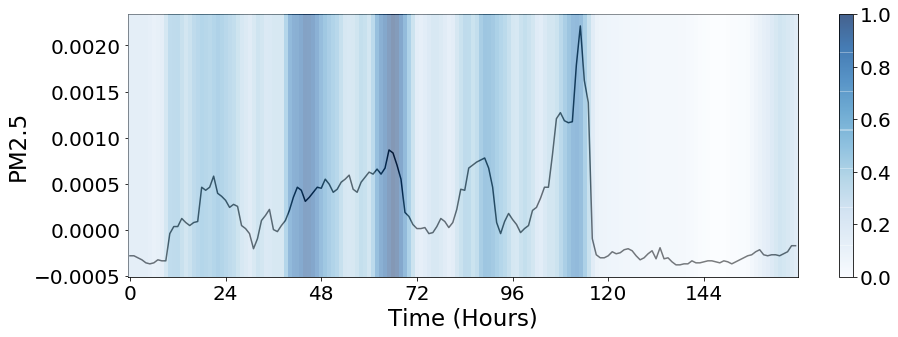

In [230]:
from scipy.ndimage import zoom
import random
import pylab

X_test=testX.copy()
id_=24*127
testX_inverse=X_test[id_][:,0]*(np.max(values)-np.min(values))+np.min(values)
testX_inverse

X_test=testX.copy()
activation = activation_grad(X_test[id_], model)
print(activation)
fig, ax = plt.subplots(1,1, figsize=(15,5))
ax.set_xticks([0,24,48,72,96,120,144,168])

plt.plot(testX_inverse/100000, 'k')
#plt.plot(yhat, label='predict')
#plt.plot(testY, label='true')
plt.ylabel('PM2.5'); plt.xlabel('Time (Hours)'); #plt.title(pd.to_datetime(test_date[sequence_length+id_]))
plt.twinx()
#plt.xticks(a)
plt.imshow(np.vstack([activation]*120), alpha=0.5, cmap='Blues')
plt.axis('off'); 
plt.colorbar()
plt.axis('off')
plt.subplots_adjust(bottom=0.15)

#pylab.pcolor(np.vstack([activation]*120),cmap='jet',alpha=0.35)

#pylab.colorbar()

np.set_printoptions(False)

plt.savefig('png/pm2.5_grad cam_cnn-lstm(1).png', dpi=300)

1.0
0.0
1.0
(1, 168, 8)


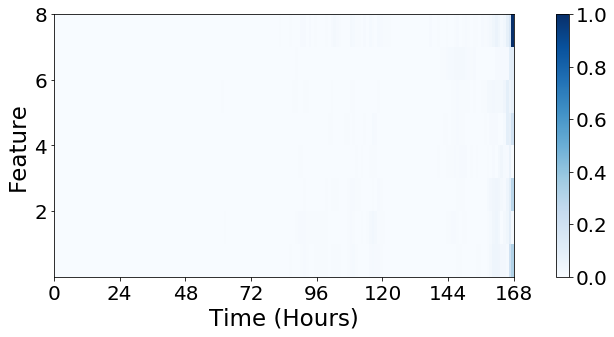

In [231]:
import matplotlib.pyplot as plt
import numpy as np

X_test=testX

grad_weight = gradient_weight(X_test[id_], model)

grad_weight_abs = abs(grad_weight)

grad_weight_abs_z = (grad_weight_abs-(np.min(grad_weight_abs)))/(np.max(grad_weight_abs)-(np.min(grad_weight_abs)))

print(np.max(grad_weight_abs_z))
print(np.min(grad_weight_abs_z))
print(np.max(grad_weight_abs_z)-np.min(grad_weight_abs_z))
#grad_weight=grad_weight.reshape(48,4)

print(grad_weight.shape)

#plt.plot(X_test[8], 'k')
a=grad_weight_abs_z.numpy()
a=a.reshape(168,8)
a=a.transpose()

#print(a)
fig, ax = plt.subplots(1,1, figsize=(15,5))

extent = [0 , 168, 0 , 8]
y_label_list = [2,4,6,8]
x_label_list = [0,24,48,72,96,120,144,168]
ax.set_xticks([0,24,48,72,96,120,144,168])

ax.set_yticks([24,48,72,96])

ax.set_xticklabels(x_label_list)
ax.set_yticklabels(y_label_list)
plt.subplots_adjust(bottom=0.15)

ax.set_xticklabels(x_label_list)
ax.set_yticklabels(y_label_list)
ax.set_ylabel('Feature')
ax.set_xlabel('Time (Hours)')

plt.imshow(a,extent = [0 , 168, 0 , 96], vmin=0, vmax=1, cmap="Blues", interpolation='nearest')
plt.colorbar()

plt.savefig('png/pm2.5_feature importance_cnn-lstm(1).png', dpi=300)

1.0
0.0
1.0
(168, 8)


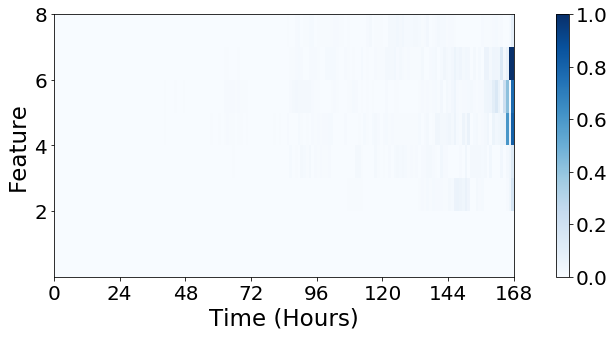

In [234]:
import matplotlib.pyplot as plt
import numpy as np

X_test=testX

grad_weight = get_integrated_gradients(X_test[id_], model, baseline = X_test[id_-1])

grad_weight_abs = abs(grad_weight)

grad_weight_abs_z = (grad_weight_abs-(np.min(grad_weight_abs)))/(np.max(grad_weight_abs)-(np.min(grad_weight_abs)))

print(np.max(grad_weight_abs_z))
print(np.min(grad_weight_abs_z))
print(np.max(grad_weight_abs_z)-np.min(grad_weight_abs_z))
#grad_weight=grad_weight.reshape(48,4)

print(grad_weight.shape)

#plt.plot(X_test[8], 'k')
a=grad_weight_abs_z.numpy()
a=a.reshape(168,8)
a=a.transpose()

#print(a)
fig, ax = plt.subplots(1,1, figsize=(15,5))

extent = [0 , 168, 0 , 8]
y_label_list = [2,4,6,8]
x_label_list = [0,24,48,72,96,120,144,168]
ax.set_xticks([0,24,48,72,96,120,144,168])

ax.set_yticks([24,48,72,96])

ax.set_xticklabels(x_label_list)
ax.set_yticklabels(y_label_list)
plt.subplots_adjust(bottom=0.15)

ax.set_xticklabels(x_label_list)
ax.set_yticklabels(y_label_list)
ax.set_ylabel('Feature')
ax.set_xlabel('Time (Hours)')

plt.imshow(a,extent = [0 , 168, 0 , 96], vmin=0, vmax=1, cmap="Blues", interpolation='nearest')
plt.colorbar()

plt.savefig('png/pm2.5_feature int_grad_cnn-lstm(1).png', dpi=300)

lstm-cnn

In [215]:
from tensorflow.keras.models import Model

first_input = Input(shape=(168,8))


in0=LSTM(64,return_sequences=True)(first_input)
#in1=add([first_input,in0])
in0=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)
#in1= BatchNormalization(scale=False)(in0)

in1=Conv1D(filters=64, kernel_size=2, activation='relu',padding='same')(in0)
#in1= BatchNormalization(scale=False)(in1)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)

in1=add([in0,in1],name='extractor1')

#ad=Dropout(0.5)(ad)
#in0=LSTM(64,return_sequences=True)(ad)
#in1=add([first_input,in0])
in0=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in0)

in1=Conv1D(filters=64, kernel_size=2, activation='relu',padding='same')(in0)
#in1= BatchNormalization(scale=False)(in1)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same',name='extractor')(in1)
#in1= BatchNormalization(scale=False)(in1)

#ad1=add([in0,in1])


#in0=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(ad1)
#in1= BatchNormalization(scale=False)(in0)

#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)
#in1= BatchNormalization(scale=False)(in1)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

#in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)

#in1=add([ad1,in1],name='extractor2')
#in0=Conv1D(filters=64, kernel_size=5, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in0)

#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)
#in1= BatchNormalization(scale=False)(in1)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

#in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)

in1=add([in0,in1])

#attn_layer = AttentionLayer(name='attention_layer')
#attn_out, attn_states = attn_layer([in1,in1]

    # Concat attention input and LSTM output, in original code it was decoder LSTM
#concat_out = Concatenate(axis=-1, name='concat_layer')([in1, attn_out])
#in1=MaxPooling1D(pool_size=2, name='extractor')(in1)
in1=Flatten()(in1)

in1=Dense(100, activation='relu')(in1)
in1=Dropout(0.5)(in1)

out=Dense(24,'relu')(in1)
model=tf.keras.Model(inputs=[first_input],outputs=[out])
model.compile(optimizer='adam', loss='mse')

checkpoint_path = "C:/Users/mozzimerci/jupyter notebook/time/chan/ff/saved_weights/pm2.5_lstmcnn_multi.hdf5"
cb = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_best_only=False,
                                        monitor='val_loss',mode='min',
                                                 verbose=1)


#history=model.fit(trainX, trainY, epochs=100, batch_size=100, validation_data=(valX, valY), verbose=1, callbacks=[cb])

In [216]:
model.load_weights("saved_weights/pm2.5_lstmcnn_multi.hdf5")

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]


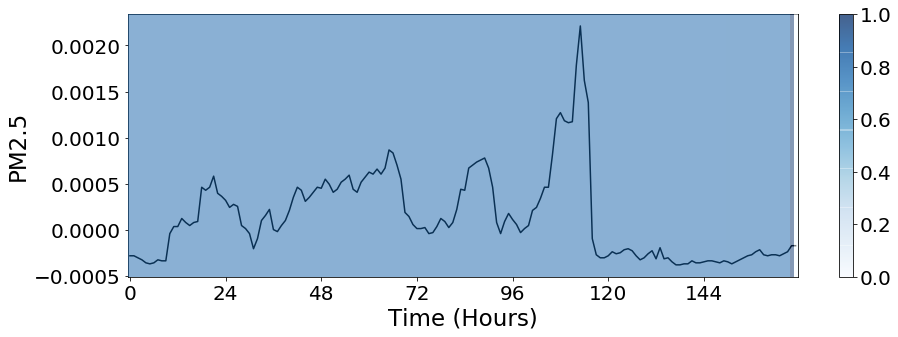

In [217]:
from scipy.ndimage import zoom
import random
import pylab

X_test=testX.copy()
id_=24*127
testX_inverse=X_test[id_][:,0]*(np.max(values)-np.min(values))+np.min(values)
testX_inverse

X_test=testX.copy()
activation = activation_grad(X_test[id_], model)
print(activation)
fig, ax = plt.subplots(1,1, figsize=(15,5))
ax.set_xticks([0,24,48,72,96,120,144,168])
plt.subplots_adjust(bottom=0.15)

plt.plot(testX_inverse/100000, 'k')
#plt.plot(yhat, label='predict')
#plt.plot(testY, label='true')
plt.ylabel('PM2.5'); plt.xlabel('Time (Hours)'); #plt.title(pd.to_datetime(test_date[sequence_length+id_]))
plt.twinx()
#plt.xticks(a)
plt.imshow(np.vstack([activation]*120), alpha=0.5, cmap='Blues')
plt.axis('off'); plt.colorbar()
plt.axis('off')
#pylab.pcolor(np.vstack([activation]*120),cmap='jet',alpha=0.35)

#pylab.colorbar()

np.set_printoptions(False)

plt.savefig('png/pm2.5_grad cam_lstm-cnn(1).png', dpi=300)

1.0
0.0
1.0
(1, 168, 8)


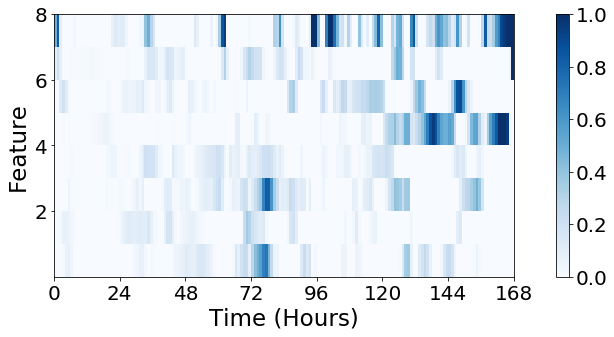

In [220]:
import matplotlib.pyplot as plt
import numpy as np

X_test=testX

grad_weight = gradient_weight(X_test[id_], model)

grad_weight_abs = abs(grad_weight)

grad_weight_abs_z = (grad_weight_abs-(np.min(grad_weight_abs)))/(np.max(grad_weight_abs)-(np.min(grad_weight_abs)))

print(np.max(grad_weight_abs_z))
print(np.min(grad_weight_abs_z))
print(np.max(grad_weight_abs_z)-np.min(grad_weight_abs_z))
#grad_weight=grad_weight.reshape(48,4)

print(grad_weight.shape)

#plt.plot(X_test[8], 'k')
a=grad_weight.numpy()
a=a.reshape(168,8)
a=a.transpose()

#print(a)
fig, ax = plt.subplots(1,1, figsize=(15,5))

extent = [0 , 168, 0 , 8]
y_label_list = [2,4,6,8]
x_label_list = [0,24,48,72,96,120,144,168]
ax.set_xticks([0,24,48,72,96,120,144,168])

ax.set_yticks([24,48,72,96])

ax.set_xticklabels(x_label_list)
ax.set_yticklabels(y_label_list)

ax.set_xticklabels(x_label_list)
ax.set_yticklabels(y_label_list)
ax.set_ylabel('Feature')
ax.set_xlabel('Time (Hours)')
plt.subplots_adjust(bottom=0.15)

plt.imshow(a,extent = [0 , 168, 0 , 96], vmin=0, vmax=1, cmap="Blues", interpolation='nearest')
plt.colorbar()

plt.savefig('png/pm2.5_feature importance_lstm-cnn(1).png', dpi=300)

1.0
0.0
1.0
(168, 8)


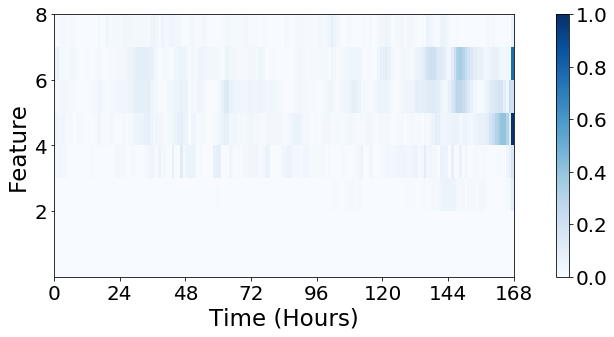

In [219]:
import matplotlib.pyplot as plt
import numpy as np

X_test=testX

grad_weight = get_integrated_gradients(X_test[id_], model, baseline = X_test[id_-1])

grad_weight_abs = abs(grad_weight)

grad_weight_abs_z = (grad_weight_abs-(np.min(grad_weight_abs)))/(np.max(grad_weight_abs)-(np.min(grad_weight_abs)))

print(np.max(grad_weight_abs_z))
print(np.min(grad_weight_abs_z))
print(np.max(grad_weight_abs_z)-np.min(grad_weight_abs_z))
#grad_weight=grad_weight.reshape(48,4)

print(grad_weight.shape)

#plt.plot(X_test[8], 'k')
a=grad_weight_abs_z.numpy()
a=a.reshape(168,8)
a=a.transpose()

#print(a)
fig, ax = plt.subplots(1,1, figsize=(15,5))

extent = [0 , 168, 0 , 8]
y_label_list = [2,4,6,8]
x_label_list = [0,24,48,72,96,120,144,168]
ax.set_xticks([0,24,48,72,96,120,144,168])

ax.set_yticks([24,48,72,96])

ax.set_xticklabels(x_label_list)
ax.set_yticklabels(y_label_list)

ax.set_xticklabels(x_label_list)
ax.set_yticklabels(y_label_list)
ax.set_ylabel('Feature')
ax.set_xlabel('Time (Hours)')
plt.subplots_adjust(bottom=0.15)

plt.imshow(a,extent = [0 , 168, 0 , 96], vmin=0, vmax=1, cmap="Blues", interpolation='nearest')
plt.colorbar()

plt.savefig('png/pm2.5_feature int_grad_lstm-cnn(1).png', dpi=300)

lstm-rescnn

In [221]:
from tensorflow.keras.models import Model

first_input = Input(shape=(168,8))


in0=LSTM(64,return_sequences=True)(first_input)
#in1=add([first_input,in0])
in0=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)
#in1= BatchNormalization(scale=False)(in0)

in1=Conv1D(filters=64, kernel_size=2, activation='relu',padding='same')(in0)
#in1= BatchNormalization(scale=False)(in1)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)

in1=add([in0,in1],name='extractor1')

#ad=Dropout(0.5)(ad)
#in0=LSTM(64,return_sequences=True)(ad)
#in1=add([first_input,in0])
in0=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in0)

in1=Conv1D(filters=64, kernel_size=2, activation='relu',padding='same')(in0)
#in1= BatchNormalization(scale=False)(in1)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same',name='extractor')(in1)
#in1= BatchNormalization(scale=False)(in1)

#ad1=add([in0,in1])


#in0=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(ad1)
#in1= BatchNormalization(scale=False)(in0)

#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)
#in1= BatchNormalization(scale=False)(in1)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

#in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)

#in1=add([ad1,in1],name='extractor2')
#in0=Conv1D(filters=64, kernel_size=5, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in0)

#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)
#in1= BatchNormalization(scale=False)(in1)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

#in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)

in1=add([in0,in1])

#attn_layer = AttentionLayer(name='attention_layer')
#attn_out, attn_states = attn_layer([in1,in1]

    # Concat attention input and LSTM output, in original code it was decoder LSTM
#concat_out = Concatenate(axis=-1, name='concat_layer')([in1, attn_out])
#in1=MaxPooling1D(pool_size=2, name='extractor')(in1)
in1=Flatten()(in1)

in1=Dense(100, activation='relu')(in1)
in1=Dropout(0.5)(in1)

out=Dense(24,'relu')(in1)
model=tf.keras.Model(inputs=[first_input],outputs=[out])
model.compile(optimizer='adam', loss='mse')

checkpoint_path = "C:/Users/mozzimerci/jupyter notebook/time/chan/ff/saved_weights/pm2.5_lstmrescnn_multi.hdf5"
cb = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_best_only=False,
                                        monitor='val_loss',mode='min',
                                                 verbose=1)

#history=model.fit(trainX, trainY, epochs=100, batch_size=100, validation_data=(valX, valY), verbose=1, callbacks=[cb])

In [222]:
model.load_weights("saved_weights/pm2.5_lstmrescnn_multi.hdf5")

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.
 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.
 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1.
 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


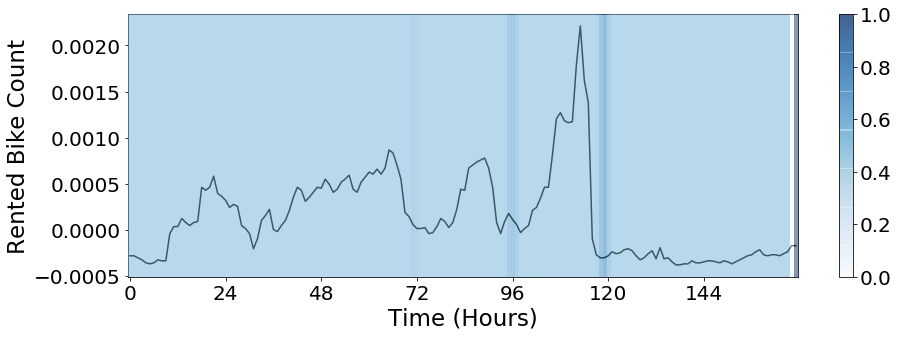

In [223]:
from scipy.ndimage import zoom
import random
import pylab

X_test=testX.copy()
id_=24*127
testX_inverse=X_test[id_][:,0]*(np.max(values)-np.min(values))+np.min(values)
testX_inverse

X_test=testX.copy()
activation = activation_grad(X_test[id_], model)
print(activation)

fig, ax = plt.subplots(1,1, figsize=(15,5))
ax.set_xticks([0,24,48,72,96,120,144,168])

plt.plot(testX_inverse/100000, 'k')
#plt.plot(yhat, label='predict')
#plt.plot(testY, label='true')
plt.ylabel('Rented Bike Count'); plt.xlabel('Time (Hours)'); #plt.title(pd.to_datetime(test_date[sequence_length+id_]))
plt.twinx()
#plt.xticks(a)
plt.imshow(np.vstack([activation]*120), alpha=0.5, cmap='Blues')
plt.axis('off'); plt.colorbar()
plt.axis('off')
#pylab.pcolor(np.vstack([activation]*120),cmap='jet',alpha=0.35)
plt.subplots_adjust(bottom=0.15)

#pylab.colorbar()

np.set_printoptions(False)

plt.savefig('png/pm2.5_grad cam_lstm-rescnn(1).png', dpi=300)

1.0
0.0
1.0
(1, 168, 8)


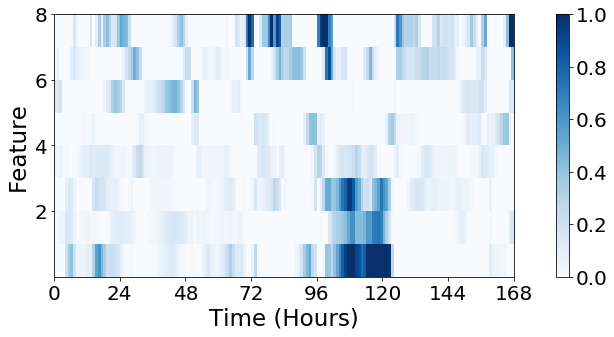

In [224]:
import matplotlib.pyplot as plt
import numpy as np

X_test=testX

grad_weight = gradient_weight(X_test[id_], model)

grad_weight_abs = abs(grad_weight)

grad_weight_abs_z = (grad_weight_abs-(np.min(grad_weight_abs)))/(np.max(grad_weight_abs)-(np.min(grad_weight_abs)))

print(np.max(grad_weight_abs_z))
print(np.min(grad_weight_abs_z))
print(np.max(grad_weight_abs_z)-np.min(grad_weight_abs_z))
#grad_weight=grad_weight.reshape(48,4)

print(grad_weight.shape)

#plt.plot(X_test[8], 'k')
a=grad_weight.numpy()
a=a.reshape(168,8)
a=a.transpose()

#print(a)
fig, ax = plt.subplots(1,1, figsize=(15,5))

extent = [0 , 168, 0 , 8]
y_label_list = [2,4,6,8]
x_label_list = [0,24,48,72,96,120,144,168]
ax.set_xticks([0,24,48,72,96,120,144,168])

ax.set_yticks([24,48,72,96])

ax.set_xticklabels(x_label_list)
ax.set_yticklabels(y_label_list)

ax.set_xticklabels(x_label_list)
ax.set_yticklabels(y_label_list)
ax.set_ylabel('Feature')
ax.set_xlabel('Time (Hours)')
plt.subplots_adjust(bottom=0.15)

plt.imshow(a,extent = [0 , 168, 0 , 96], vmin=0, vmax=1, cmap="Blues", interpolation='nearest')
plt.colorbar()

plt.savefig('png/pm2.5_feature importance_lstm-rescnn(1).png', dpi=300)

1.0
0.0
1.0
(168, 8)


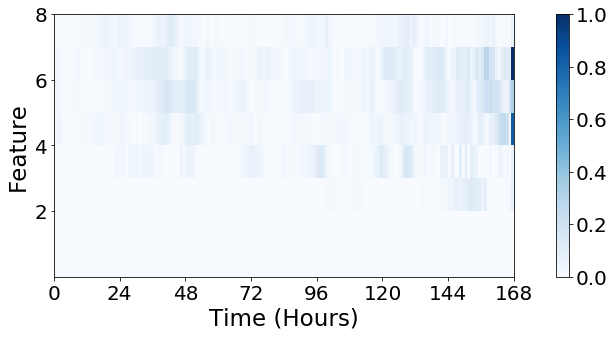

In [227]:
import matplotlib.pyplot as plt
import numpy as np

X_test=testX

grad_weight = get_integrated_gradients(X_test[id_], model, baseline = X_test[id_-1])

grad_weight_abs = abs(grad_weight)

grad_weight_abs_z = (grad_weight_abs-(np.min(grad_weight_abs)))/(np.max(grad_weight_abs)-(np.min(grad_weight_abs)))

print(np.max(grad_weight_abs_z))
print(np.min(grad_weight_abs_z))
print(np.max(grad_weight_abs_z)-np.min(grad_weight_abs_z))
#grad_weight=grad_weight.reshape(48,4)

print(grad_weight.shape)

#plt.plot(X_test[8], 'k')
a=grad_weight_abs_z.numpy()
a=a.reshape(168,8)
a=a.transpose()

#print(a)
fig, ax = plt.subplots(1,1, figsize=(15,5))

extent = [0 , 168, 0 , 8]
y_label_list = [2,4,6,8]
x_label_list = [0,24,48,72,96,120,144,168]
ax.set_xticks([0,24,48,72,96,120,144,168])

ax.set_yticks([24,48,72,96])

ax.set_xticklabels(x_label_list)
ax.set_yticklabels(y_label_list)

ax.set_xticklabels(x_label_list)
ax.set_yticklabels(y_label_list)
ax.set_ylabel('Feature')
ax.set_xlabel('Time (Hours)')
plt.subplots_adjust(bottom=0.15)

plt.imshow(a,extent = [0 , 168, 0 , 96], vmin=0, vmax=1, cmap="Blues", interpolation='nearest')
plt.colorbar()

plt.savefig('png/pm2.5_feature int_grad_lstm-rescnn(1).png', dpi=300)